# `DESCRIPTION`: This is case project of building price prediction model for IKEA dataset.

# `Topics covered`: EDA, data viz, hypothesis testing, training / testing pull of models to find out that works best. 

# `Business case`: predicting price / category of product while user is searching can substantially decrease database load and optimize conversion strategy

### Import all needed packeges and data to DataFrame

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
# deprecation warnings off
import warnings
warnings.filterwarnings("ignore")

# styling and matplotlib config
%matplotlib inline
sns.set(style='whitegrid')

# read CSV with parameters index_col=0 to specify index column in given CSV, 
# and drop duplicates inplace
df_raw = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv",
                 index_col=0).drop_duplicates()
df = df_raw.copy()
df.head()

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0


### Exploratory Data Analysis

In [2]:
# get the types and non-null counts of DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3694 entries, 0 to 3693
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   item_id            3694 non-null   int64  
 1   name               3694 non-null   object 
 2   category           3694 non-null   object 
 3   price              3694 non-null   float64
 4   old_price          3694 non-null   object 
 5   sellable_online    3694 non-null   bool   
 6   link               3694 non-null   object 
 7   other_colors       3694 non-null   object 
 8   short_description  3694 non-null   object 
 9   designer           3694 non-null   object 
 10  depth              2231 non-null   float64
 11  height             2706 non-null   float64
 12  width              3105 non-null   float64
dtypes: bool(1), float64(4), int64(1), object(7)
memory usage: 378.8+ KB


There are 3694 values in total. Only product dimensions have empty values.

In [3]:
# counts of null enties in data by columns
print(df.isnull().sum())

item_id                 0
name                    0
category                0
price                   0
old_price               0
sellable_online         0
link                    0
other_colors            0
short_description       0
designer                0
depth                1463
height                988
width                 589
dtype: int64


In [4]:
# unique categories and their counts
print(len(df.category.unique()),'\n')
for elem in df.category.unique():
    print(elem)

17 

Bar furniture
Beds
Bookcases & shelving units
Cabinets & cupboards
Café furniture
Chairs
Chests of drawers & drawer units
Children's furniture
Nursery furniture
Outdoor furniture
Room dividers
Sideboards, buffets & console tables
Sofas & armchairs
Tables & desks
Trolleys
TV & media furniture
Wardrobes


In [5]:
# Drop NA data from DataFrame and check counts
df = df.dropna() 
df.count()

item_id              1899
name                 1899
category             1899
price                1899
old_price            1899
sellable_online      1899
link                 1899
other_colors         1899
short_description    1899
designer             1899
depth                1899
height               1899
width                1899
dtype: int64

In [6]:
# calculate the number of products in each category
df_cat_counts = df.groupby('category').agg(Prod_Counts=('price','count'))
df_cat_counts

,Prod_Counts
category,
Bar furniture,24
Beds,78
Bookcases & shelving units,375
Cabinets & cupboards,199
Café furniture,13
Chairs,213
Chests of drawers & drawer units,121
Children's furniture,78
Nursery furniture,62


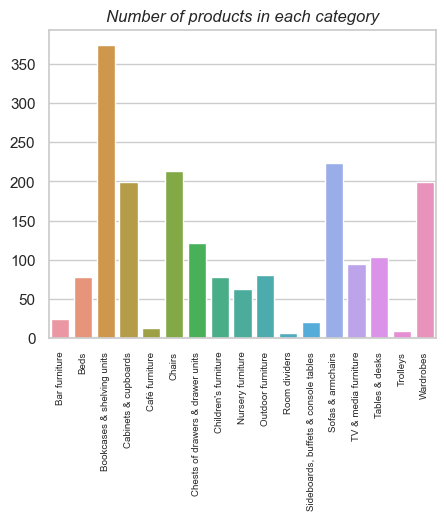

In [7]:
# plot the number of products in each category
# other variant: sns.countplot(x=df['category']).set_xticklabels(df['category'].unique(), rotation=90)
ax = sns.barplot(x=df_cat_counts.index,y=df_cat_counts.Prod_Counts)
ax.set_title('Number of products in each category', fontdict={'size':12,'style':'italic'})
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 7, rotation=90)
ax.figure.set_size_inches((5,4))
plt.show()

In [8]:
# Remove obviously "useless" columns 
df = df.drop(['item_id', 'link'], axis=1)
df.columns

Index(['name', 'category', 'price', 'old_price', 'sellable_online',
       'other_colors', 'short_description', 'designer', 'depth', 'height',
       'width'],
      dtype='object')

In [9]:
# check quantitative characteristics of selected category data
df[df.category == "Bar furniture"].describe()

,price,depth,height,width
count,24.000000,24.000000,24.000000,24.000000
mean,338.416667,47.541667,94.666667,45.833333
std,184.885844,5.356663,17.061695,8.095445
min,69.000000,36.000000,43.000000,38.000000
25%,175.000000,44.000000,90.750000,40.000000
50%,345.000000,47.500000,100.500000,43.000000
75%,405.000000,51.000000,103.000000,50.000000
max,745.000000,60.000000,114.000000,74.000000


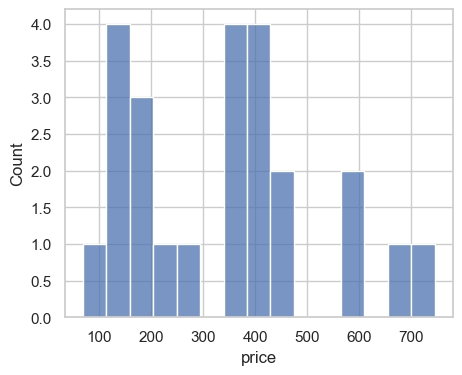

In [10]:
# plot the distrubution of selected category price data 
df_bar_furniture = df[df.category == "Bar furniture"]
# to set correct bin number see count of products in each category
ax = sns.histplot(df_bar_furniture.price, bins=15)
ax.figure.set_size_inches((5,4))
plt.show()

### Feature selection for categorical and numerical data

[0 1 3]
[[ 100.   60.   69.]
 [  43.   74.  225.]
 [  91.   40.  345.]
 ...
 [ 236.  100. 2100.]
 [ 236.  150. 3985.]
 [ 236.  200. 2045.]]


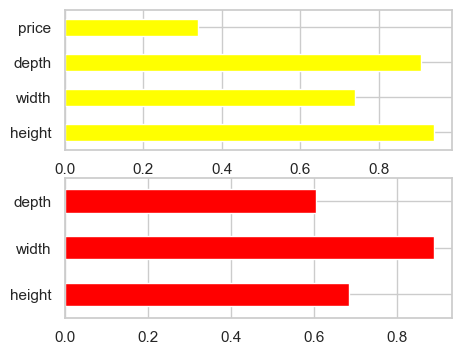

In [11]:
from sklearn.feature_selection import mutual_info_classif,mutual_info_regression
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

_, (ax1,ax2) = plt.subplots(2,1)

df_X = df[['height', 'width', 'depth', 'price']]
df_y = df['category']

importance_0 = mutual_info_classif(df_X, df_y)
feature_importances = pd.Series(importance_0, df_X.columns)
feature_importances.plot(kind='barh', color='yellow',ax=ax1)
ax1.figure.set_size_inches((5,4))

df_X_1 = df[['height', 'width', 'depth']]
df_y_1 = df['price']

importance_1 = mutual_info_regression(df_X_1, df_y_1)
feature_importances_1 = pd.Series(importance_1, df_X_1.columns)
feature_importances_1.plot(kind='barh', color='red',ax=ax2)
ax2.figure.set_size_inches((5,4))

chi2_features = SelectKBest(chi2, k = 3)
X_kbest_features = chi2_features.fit(df_X, df_y)
print(X_kbest_features.get_support(indices=True))

transformed_X = chi2_features.transform(df_X)
print(transformed_X)
plt.show()

#### Regularization consists of adding a penalty to various model parameters to avoid overfitting. When regularizing a linear model, a penalty is applied to the coefficients multiplying each of the predictors. Lasso regularization has the property of reducing some coefficients to zero. Therefore, such “features” can simply be removed from the model.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# set regularization parameter C=1, the smaller the value - the stronger the regularization
# df_X, df_y are input and output respectively
logistic = LogisticRegression(C=1, penalty="l1", solver='liblinear', random_state=7).fit(df_X, df_y)
# create meta-transformer for selecting features based on importance weights
model = SelectFromModel(logistic, prefit=True, max_features=3, threshold='0.8*mean')
# transforming data
X_new = model.transform(df_X)

print(model.get_support(indices=True),X_new,sep='\n')

[0 1 2]
[[100.  60.  50.]
 [ 43.  74.  60.]
 [ 91.  40.  45.]
 ...
 [236. 100.  60.]
 [236. 150.  66.]
 [236. 200.  66.]]


In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# select features according to the k highest scores
# score function f_regression
selector = SelectKBest(f_regression, k=2).fit(df_X_1, df_y_1)
data = selector.transform(df_X_1)
print(selector.scores_, selector.get_support(indices=True), data)

[ 152.24015162 2753.30085838 1213.01136312] [1 2] [[ 60.  50.]
 [ 74.  60.]
 [ 40.  45.]
 ...
 [100.  60.]
 [150.  66.]
 [200.  66.]]


In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_X_1_scaled = pd.DataFrame(scaler.fit_transform(df_X_1), columns = df_X_1.columns)
df_X_1_scaled.head()

,height,width,depth
0,0.327759,0.138756,0.191406
1,0.137124,0.172249,0.230469
2,0.297659,0.090909,0.171875
3,0.311037,0.114833,0.167969
4,0.311037,0.114833,0.167969


In [15]:
# removing features with low variance
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(0.02)
selector.fit(df_X_1_scaled)
df_X_1_scaled.columns[selector.get_support()]

Index(['height', 'width'], dtype='object')

In [16]:
selector.variances_

array([0.04401907, 0.03437102, 0.01426107])

In [17]:
# tree-based feature selection
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=3)
model.fit(df_X_1, df_y_1)
importances = model.feature_importances_
print(importances)

[0.09418974 0.71406447 0.1917458 ]


In [18]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=4)
model.fit(df_X, df_y)
importances = model.feature_importances_
print(importances)

[0.28834013 0.18590226 0.29676007 0.22899754]


Histograms for selected colomuns

price


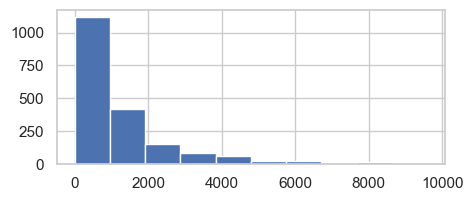

depth


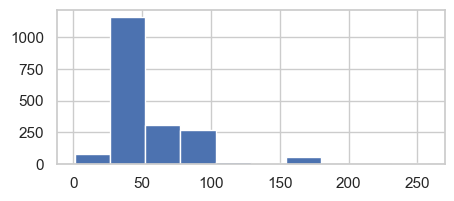

height


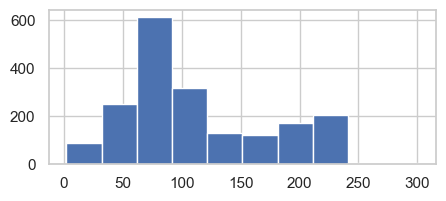

width


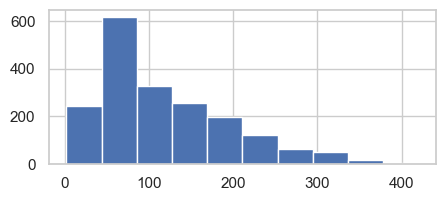

In [19]:
for col in ['price', 'depth', 'height', 'width']:
    print(col)
    plt.figure(figsize=(5,2))
    plt.hist(df[col])   
    plt.show()

According to the histograms, it can be assumed that these values have a lognormal distribution.

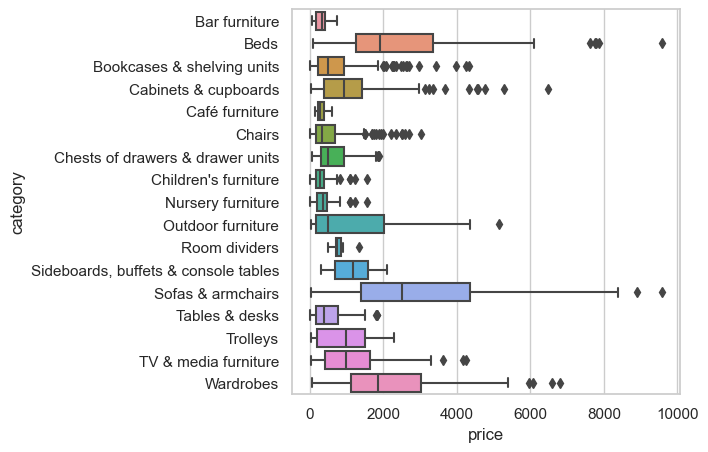

In [20]:
plt.subplots(figsize=(5,5))
sns.boxplot(data=df, x='price', y='category')
plt.show()

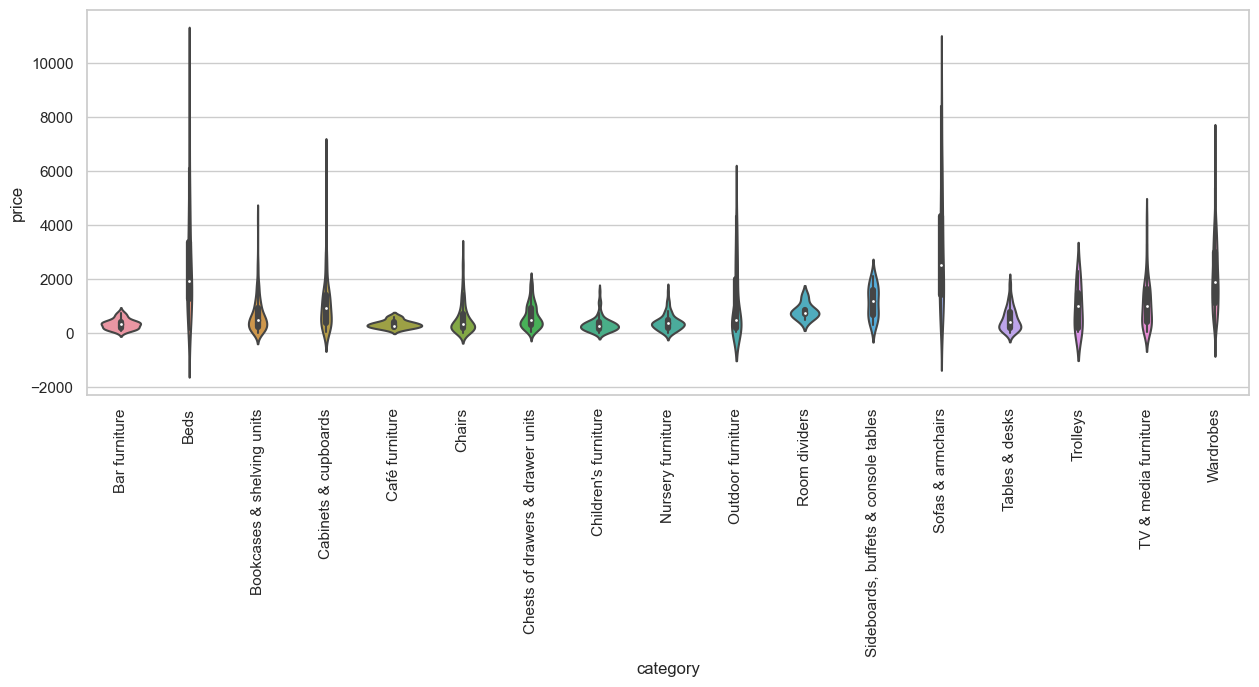

In [21]:
plt.subplots(figsize=(15,5))
sns.violinplot(data=df, y='price', x='category')
plt.xticks(rotation=90)
plt.show()

Almost all categories have outliers from the side of maximum prices.

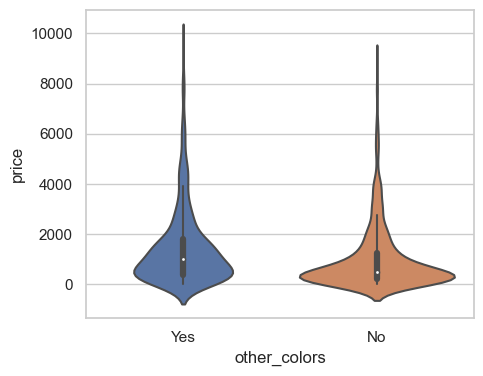

In [22]:
plt.subplots(figsize=(5,4))
sns.violinplot(data=df, y='price', x='other_colors')
plt.show()

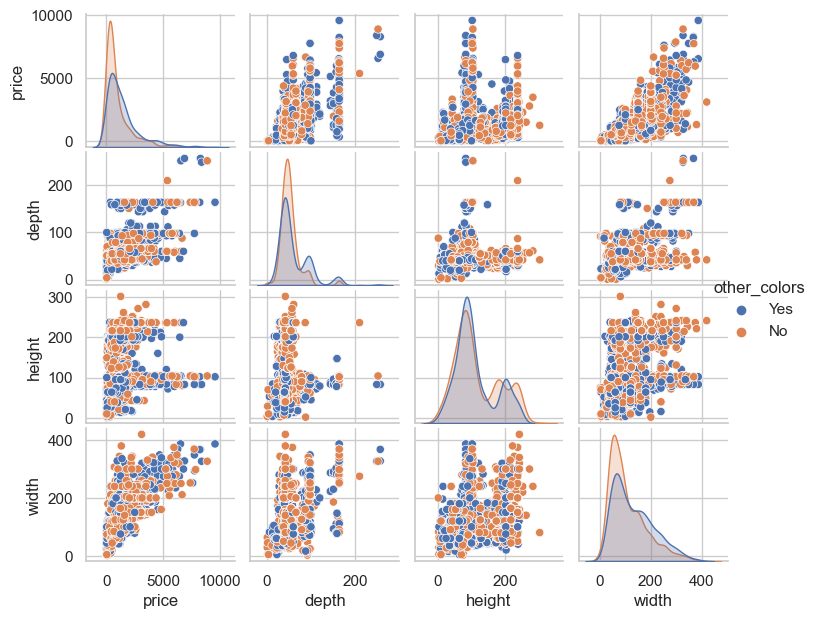

In [23]:
ax = sns.pairplot(df[['price','depth','height','width','other_colors','category']], hue='other_colors')
ax.figure.set_size_inches((8,6))
plt.show()

It appears that the prices of items that have multiple colors and the prices of single-color items have the same distribution.

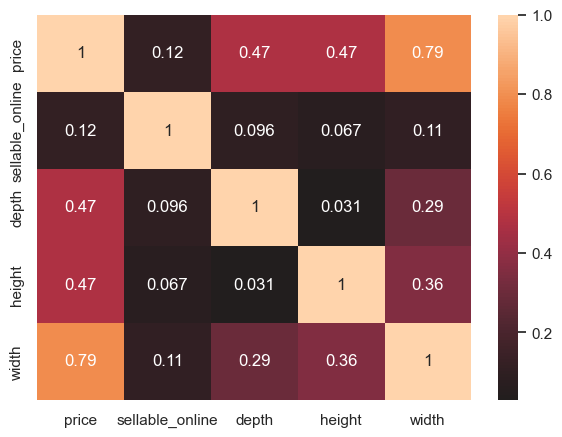

In [24]:
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(method='spearman'), xticklabels=df.corr().columns, yticklabels=df.corr().columns, center=0, annot=True)
plt.show()

There is some correlation between the price and dimensions of the product.

### Hypothesis testing

##### Hypothesis #1

Based on the price histogram, one could assume that the price has a lognormal distribution. If a random variable has a lognormal distribution, then its logarithm has a normal distribution. Let's build a histogram for the logarithm of prices and test the hypothesis H_0 that prices have a normal distribution.

3       1.838849
4       2.352183
5       2.537819
6       2.110590
8       2.110590
          ...   
3683    3.100371
3684    3.095169
3685    3.322219
3686    3.600428
3688    3.310693
Name: price, Length: 1899, dtype: float64


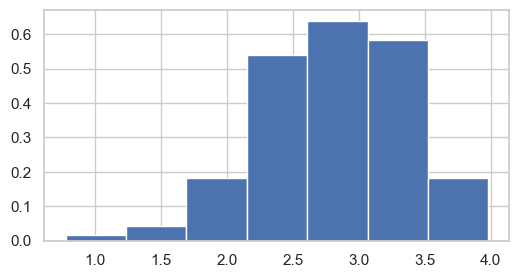

In [25]:
plt.figure(figsize=(6,3))
plt.hist(np.log10(df.price), bins=7,density=True)
print(np.log10(df.price))
plt.show()

3      -1.825636
4      -0.861883
5      -0.513361
6      -1.315459
8      -1.315459
          ...   
3683    0.542796
3684    0.533031
3685    0.959304
3686    1.481625
3688    0.937665
Name: price, Length: 1899, dtype: float64


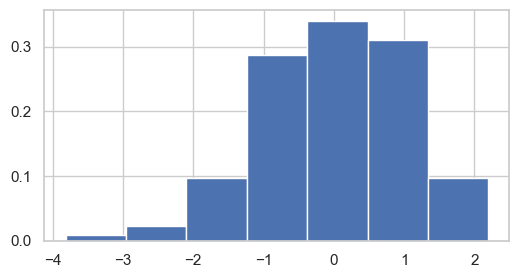

In [26]:
# data standardization
sample_h = (np.log10(df.price)-np.log10(df.price).mean())/np.log10(df.price).std()
print(sample_h)
plt.figure(figsize=(6,3))
hist_h = plt.hist(sample_h, bins=7,density=True)
plt.show()

##### Shapiro criterion and other tests to test the hypothesis of normal distribution.

In [27]:
h0_1_p_value = stats.shapiro(sample_h).pvalue
h0_1_p_value_1 = stats.shapiro(np.log10(df.price)).pvalue
h0_1_p_value_2 = stats.kstest(sample_h, cdf=stats.norm.cdf).pvalue
h0_1_p_value_3 = stats.normaltest(sample_h).pvalue
h0_1_p_value_4 = stats.ks_2samp(sample_h, stats.norm.rvs(size=len(sample_h))).pvalue
h0_1_p_value_5 = stats.mannwhitneyu(sample_h, stats.norm.rvs(size=len(sample_h))).pvalue

print(f'p-value:',h0_1_p_value,h0_1_p_value_1,h0_1_p_value_2,h0_1_p_value_3,h0_1_p_value_4,h0_1_p_value_5,
      sep="\n")

p-value:
1.797537466097232e-11
1.798198569213927e-11
0.003314698256146518
1.1309131841046394e-10
0.3185993778711317
0.37553028724220106


Since the p-value is very small, the Shapiro test rejects our null hypothesis with a high degree of confidence, although you cannot tell from the histograms. Perhaps the histograms had very few bins. We will increase the number of baskets to 50.

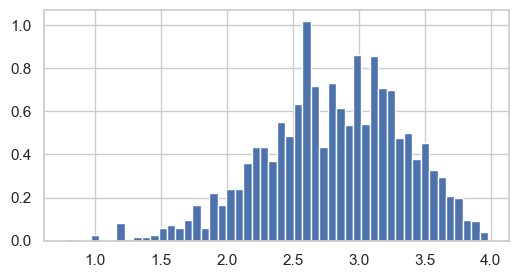

In [28]:
plt.figure(figsize=(6,3))
plt.hist(np.log10(df.price), bins=50,density=True)
plt.show()

Multiple emissions are visible to the left and right of the dome. The hypothesis about the normal distribution of prices turned out to be untenable.

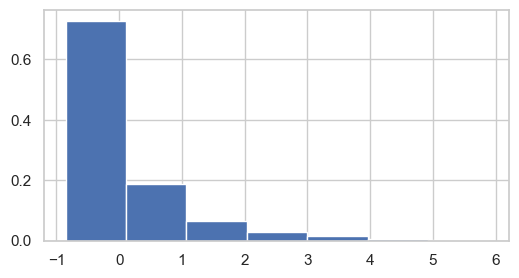

In [29]:
sample_h_2 = pd.DataFrame(((df.price)-(df.price).mean())/(df.price).std())
plt.figure(figsize=(6,3))
hist_h_2 = plt.hist(sample_h_2, bins=7,density=True)
plt.show()

Could it be Poisson?

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html

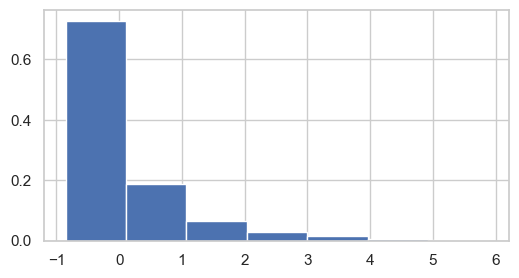

In [30]:
# second variant - to use StandardScaler transformer
from sklearn import preprocessing
scale_features_std = preprocessing.StandardScaler()
scaled_price = scale_features_std.fit_transform(np.array(df.price).reshape(-1, 1)) 
plt.figure(figsize=(6,3))
hist_scaled_price = plt.hist(scaled_price, bins=7,density=True)
plt.show()

##### Hypothesis #2

Let's test the hypothesis that the prices of goods that have several colors are not statistically different from the prices of goods of the same color.

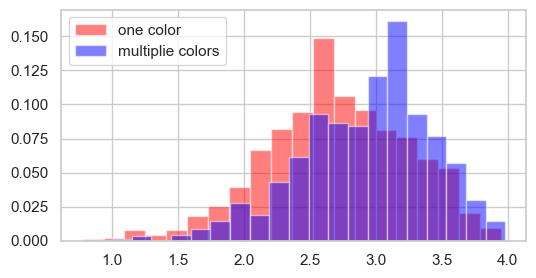

In [31]:
one_color = df[df['other_colors'] == 'No']['price'].apply(np.log10)
mult_color = df[df['other_colors'] == 'Yes']['price'].apply(np.log10)
one_color.name, mult_color.name = 'one color', 'multiplie colors'

plt.figure(figsize=(6,3))
one_color.hist(alpha=0.5, color='red', weights=[1./len(one_color)]*len(one_color), bins=20)
mult_color.hist(alpha=0.5, color='blue', weights=[1./len(mult_color)]*len(mult_color), bins=20)
plt.legend([one_color.name, mult_color.name])
plt.show()

We already know that the price does not have a normal distribution. Let's check the Mann-Whitney test (it works with non-normal distribution and unpaired samples).

In [32]:
stats.mannwhitneyu(one_color, mult_color).pvalue

1.0015089882617485e-21

p-value - less than 0.01, the hypothesis is rejected. The difference in prices for multi-color and single-color products is statistically significant. Since the distribution of prices does not differ significantly from the normal distribution, we calculate the p-value of Student's t-test.

In [33]:
stats.ttest_ind(one_color, mult_color, equal_var=False).pvalue

4.285869568191805e-21

This test also confirms the failure of our hypothesis H0.

### Building a furniture price prediction model

Which columns should not be included in the model and why?

`item_id`, `link` are not needed as they are unique for each product and will not help in any way to predict the price.

`short_description` and `name` - These fields could be used, for example, if the description contains the word "exclusive", then the price is likely to be higher. But we will not use them in our model and therefore they can be removed too.

We can also remove the `sellable_online` column since it is not representative.

##### Cleaning raw data

During the EDA phase, we found that some fields had empty values or "garbage".

_Dimensions_

We descovered nulls in dimensions. There are several strategies for filling empty dimension values:

1. You can simply delete all lines that have empty values (as we did before)
2. Use the SimpleImputer of the sklearn library and fill in the empty values with some (for example, median) value.
3. Come up with your own version

_Designers_

The `designer` column contains "garbage" (strings starting with numbers) that will need to be removed and somehow filled with empty values. On closer inspection, you can see that some products were developed by a group of designers, for example
```
Francis Cayouette/K Hagberg/M Hagberg
K Hagberg/M Hagberg/Francis Cayouette
```
and you can also notice that in this case the strings are different, but the composition of the designers is the same. Common sense dictates that you need to bring all the lines to the same form, for example, we can sort the names of designers alphabetically.

Also, a lot (about 30%) of the products have the line `IKEA of Sweden` in the list of designers. Considering that all these products are made by IKEA, this value is also probably garbage.


In [46]:
df['designer'].value_counts()

IKEA of Sweden                                                                                                                                                                                                                                                                                                                            427
Ola Wihlborg                                                                                                                                                                                                                                                                                                                              100
Jon Karlsson                                                                                                                                                                                                                                                                                                                               8

In [34]:
def cleanDesigners(value, removeIKEA=False, emptyValue=np.nan):
    '''
    Procedure for bringing the designer column to "normal view"
    value - string, composition of designers
    removeIKEA - remove or not IKEA of Sweden
    emptyValue - with what to replace invalid values, default - np.nan
    '''
    # if it's not a string, return the value itself
    if not isinstance(value, str):
        return value
    # if the string starts with a digit, return an empty value
    if len(value)>0 and value[0].isdigit():
        return emptyValue
    # split the string by /
    designers = value.split("/")
    if removeIKEA:
        # trying to remove "IKEA of Sweden"
        try:
            designers.remove("IKEA of Sweden")
        except:
            pass
    if len(designers) > 0:
        # return a string sorted by designer names
        return '/'.join(sorted(designers))
    else:
        # or an empty string if the list is empty
        return emptyValue


Let's reload raw data into df variable and add a new column `designer_clean` - with information from designer column excluding garbage, with a sorted list of designers and filled in empty values with "IKEA of Sweden".


In [42]:
df = df_raw.copy()
df["designer_clean"] = df["designer"].apply(cleanDesigners, args=(False, "IKEA of Sweden")) #error to nan
df["designer_clean"].value_counts()

IKEA of Sweden                                                     971
Ehlén Johansson                                                    161
Francis Cayouette                                                  151
Ehlén Johansson/IKEA of Sweden                                     145
Ola Wihlborg                                                       134
                                                                  ... 
Eva Lilja Löwenhielm/IKEA of Sweden/Jon Karlsson                     1
A Huldén/S Dahlman                                                   1
Ehlén Johansson/Fredriksson/Hilland/IKEA of Sweden/L Löwenhielm      1
Malin Unnborn                                                        1
Lars Norinder                                                        1
Name: designer_clean, Length: 199, dtype: int64

In [44]:
# re-check for nulls
df.isnull().sum()

item_id                 0
name                    0
category                0
price                   0
old_price               0
sellable_online         0
link                    0
other_colors            0
short_description       0
designer                0
depth                1463
height                988
width                 589
designer_clean          0
dtype: int64

##### Dealing with nulls

We will use  the capabilities of `SimpleImputer` from `Scikit-Learn` to fill in the missing values for dimensions. We also need to translate categorical variables into digital form. Since product categories are unordered data, we will use OneHotEncoder and build the corresponding Pipeline

Since we want to predict the price - a real number, we will use one of the regressors - `DecisionTreeRegressor()`

`Scikit-Learn` provides a Pipeline class to deal with transformation sequences.

`The Pipeline` constructor accepts a list of 'name/estimator': pairs specifying a sequence of steps. All but the last evaluator must be transformers (i.e. they must have a fit_transform() method). Names can be anything (as long as they do not contain two underscores (__ )). Calling the fit() method of the pipeline causes the fit_transform() methods of all the transformers to be called in sequence, passing the output of each call as a parameter to the next call, until the last estimator is reached, for which the fit() method is called.


In [45]:
# lets define input, output and spilt data to training and testing sets
X = df[['depth','width','height','category','designer_clean','other_colors']]
Y = df['price']
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

numeric_transf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('impute', SimpleImputer(strategy='median'))
])

categorical_transf = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

col_prepr = ColumnTransformer(transformers=[
    ('numeric', numeric_transf, ['depth','width','height']),
    ('categorical', categorical_transf, ['category','designer_clean','other_colors'])
])

dtr = Pipeline(steps=[
    ('col_prep', col_prepr),
    # ('dtr', RandomForestRegressor(max_depth = 100))
    ('dtr', DecisionTreeRegressor(max_depth = 10, random_state=42))
])

dtr.fit(X_train, Y_train)
dtr_predict = dtr.predict(X_test)
print('R^2 : {:.5f}'.format(dtr.score(X_test, Y_test)))
print('MAE : {:.5f}'.format(sk.metrics.mean_absolute_error(dtr_predict, Y_test)))
print('MSE : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(dtr_predict, Y_test))))


R^2 : 0.74147
MAE : 396.26201
MSE : 705.91036


Our first model showed the following result:
```
 R^2 : 0.74147
 MAE : 396.26201
 MSE : 705.91036
```

The following steps can be taken to improve the forecast:

1. Choose a different strategy for filling in the missing dimensions.
2. Use a different Encoder for categories and designers.
3. Pick up another regressor.
4. Search for best performing regressor parameters.

Let's take a look at these steps.

In the original model, we filled in the missing values of dimensions with the median value for the entire dataset. This is not entirely correct, since we have 17 different categories, each of which has its own mean and median. Apparently, it would be more correct to fill in the missing values of dimensions with the average value for each category.

It makes sense to encode categories and designers with an average (median) price for the category.

In [46]:
df["other_colors_1"] = df["other_colors"].map(dict(Yes=1, No=0))

# calculate the average value of each dimension by category
median_d = df.groupby(['category'])['depth'].median()
median_h = df.groupby(['category'])['height'].median()
median_w = df.groupby(['category'])['width'].median()

# get median price for each category and each designer
median_price = df.groupby(['category'])['price'].median()
median_dsgn = df.groupby(['designer_clean'])['price'].median()

# create transformed columns for depth, height, width and median price
df = df.set_index(['category'])
df['depth_1'] = df['depth'].fillna(median_d)
df['height_1'] = df['height'].fillna(median_h)
df['width_1'] = df['width'].fillna(median_w)
df['category_median_price'] = median_price
df = df.reset_index()

df = df.set_index(['designer_clean'])
df['designer_median_price'] = median_dsgn
df = df.reset_index()

df.head()

,designer_clean,category,item_id,name,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width,other_colors_1,depth_1,height_1,width_1,category_median_price,designer_median_price
0,Nicholai Wiig Hansen,Bar furniture,90420332,FREKVENS,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0,0,47.0,99.0,51.0,445.0,265.0
1,Francis Cayouette,Bar furniture,368814,NORDVIKEN,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0,0,47.0,105.0,80.0,445.0,458.0
2,Francis Cayouette,Bar furniture,9333523,NORDVIKEN / NORDVIKEN,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN,0,47.0,102.0,48.0,445.0,458.0
3,Henrik Preutz,Bar furniture,80155205,STIG,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0,1,50.0,100.0,60.0,445.0,495.0
4,Marcus Arvonen,Bar furniture,30180504,NORBERG,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0,0,60.0,43.0,74.0,445.0,150.0


#### Get best regressor procedure

In [48]:
def getBestRegressor(X, Y):
    '''
    Takes X, Y - input and output data in matrix view.
    Function will find best regressor from testing of predefined inside
    model list, using give data.
    Returns dictionary with results.
    '''
    # data split
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)
    
    # list of models to test
    models = [
        sk.linear_model.LinearRegression(),
        sk.linear_model.LassoCV(),
        sk.linear_model.RidgeCV(),
        sk.svm.SVR(kernel='linear'),
        sk.neighbors.KNeighborsRegressor(n_neighbors=16),
        sk.tree.DecisionTreeRegressor(max_depth=10, random_state=42),
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor()
    ]

    TestModels = pd.DataFrame()
    res = {}
    tmp = {}
    # for each model from the list
    for model in models:
        # get model name
        m = str(model)
        tmp['Model'] = m[:m.index('(')]    
        # train model
        model.fit(X_train, Y_train) 
        # calculate R^2 - coefficient of determination
        tmp['R^2'] = '{:.5f}'.format(model.score(X_test, Y_test))
        # calculate MAE - mean absolute error 
        tmp['MAE'] = '{:.5f}'.format(sk.metrics.mean_absolute_error(model.predict(X_test), Y_test))
        # calculate RMSE
        tmp['RMSE'] = '{:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(model.predict(X_test), Y_test)))
        # aggregate data
        TestModels = pd.concat([TestModels, pd.DataFrame([tmp])])
    # prepare dict with results
    TestModels.set_index('Model', inplace=True)
    res['model'] = TestModels
    res['X_train'] = X_train
    res['Y_train'] = Y_train
    res['X_test'] = X_test
    res['Y_test'] = Y_test
    return res


##### Test №1

Let's take newly prepared data where categories and designers are encoded by the median price calculated for each category / designer separetly.

In [50]:
X1 = df[['width_1','depth_1','height_1','category_median_price','designer_median_price','other_colors_1']]
Y1 = df['price']

test1 = getBestRegressor(X1, Y1)
test1['model'].sort_values(by='R^2', ascending=False)

,R^2,MAE,RMSE
Model,,,
RandomForestRegressor,0.83172,295.91918,569.52431
GradientBoostingRegressor,0.80952,361.15451,605.93247
DecisionTreeRegressor,0.78065,355.57681,650.23047
KNeighborsRegressor,0.71362,421.49250,742.96598
RidgeCV,0.70158,481.15388,758.41414
LinearRegression,0.70156,481.28499,758.43942
LassoCV,0.70152,473.40099,758.49673
SVR,0.68826,448.43841,775.16172


The best result was shown by RandomForestRegressor with `R^2 = 0.83172`

The decision tree in this test also showed improved result with `R^2 = 0.78065` (was `0.74147`)

In [53]:
len(df.dropna(subset=['width','height','depth']))

1899

##### Test №2

Let's delete all rows with empty values in dimensions. Categories and designers are encoded by the median prices respectively.

In [54]:
df2 = df.dropna(subset=['width','height','depth'])
X2 = df2[['width','depth','height','category_median_price','designer_median_price','other_colors_1']]
Y2 = df2['price']

test2 = getBestRegressor(X2, Y2)
test2['model'].sort_values(by='R^2', ascending=False)

,R^2,MAE,RMSE
Model,,,
RandomForestRegressor,0.88104,326.01461,570.81199
GradientBoostingRegressor,0.86087,365.63349,617.29404
DecisionTreeRegressor,0.83272,374.27473,676.87191
RidgeCV,0.75505,538.95780,819.07733
LinearRegression,0.75501,538.99756,819.14734
LassoCV,0.75392,537.33236,820.96933
SVR,0.70911,535.16390,892.59118
KNeighborsRegressor,0.69949,530.48648,907.22940


The `R^2` estimates of the models have improved. RandomForestRegressor still shows the best result.

It is worth paying attention to the fact that although the `R^2` score has improved, the `MAE` has become larger. Most likely this is the result of the fact that in first test we filled in a large number of empty values with the category average.

##### Test №3

Let's try to remove "IKEA of Sweden" from the list of designers in case the list of designers contains other names. For example we have
```
designer count
Ehlén Johansson 161
Ehlén Johansson/IKEA of Sweden 145
```
after transformation we will have
```
designer count
Ehlén Johansson 306
```

In [56]:
df["designer_clean_2"] = df["designer"].apply(cleanDesigners, args=(True, "IKEA of Sweden"))

median_dsgn_2 = df.groupby(['designer_clean_2'])['price'].median()

df = df.set_index(['designer_clean_2'])
df['designer_median_price_2'] = median_dsgn_2
df = df.reset_index()

df["designer_clean_2"].value_counts()

IKEA of Sweden                        971
Ehlén Johansson                       306
Jon Karlsson                          170
Ola Wihlborg                          165
Francis Cayouette                     164
                                     ... 
E Thomasson/P Süssmann                  1
Magnus Elebäck                          1
Andreas Fredriksson/Marcus Arvonen      1
Lars Norinder                           1
Lisel Garsveden                         1
Name: designer_clean_2, Length: 157, dtype: int64

In [57]:
df3 = df.dropna(subset=['width','depth','height'])
X3 = df3[['width','depth','height','category_median_price','designer_median_price_2','other_colors_1']]
Y3 = df3['price']

test3 = getBestRegressor(X3, Y3)
test3['model'].sort_values(by='R^2', ascending=False)

,R^2,MAE,RMSE
Model,,,
RandomForestRegressor,0.88129,326.26835,570.19801
GradientBoostingRegressor,0.86147,371.29767,615.96724
DecisionTreeRegressor,0.80632,403.59155,728.33313
KNeighborsRegressor,0.74928,502.17479,828.67375
LassoCV,0.74099,555.87528,842.26185
RidgeCV,0.74099,557.54452,842.25119
LinearRegression,0.74095,557.58138,842.32463
SVR,0.69356,554.12453,916.12583


The result has not changed much.

The best results were shown by RandomForestRegressor in Test №3.

###### Cross-validation and hyperparameters tuning

Let's use the GridSearchCV function that will evaluate all possible combinations of hyperparameter values for RandomForestRegressor using cross-validation.

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Estimator : RandomForestRegressor(max_depth=100, max_features='sqrt', n_estimators=120)
Best Score     : 0.864074133295093

R^2            : 0.87573
MAE            : 329.04796
RMSE           : 583.40488

Feature importance:
--------------------------------
0.44457    width
0.17120    depth
0.09446    height
0.09795    category_median_price
0.17682    designer_median_price
0.01499    other_colors_1


<AxesSubplot:>

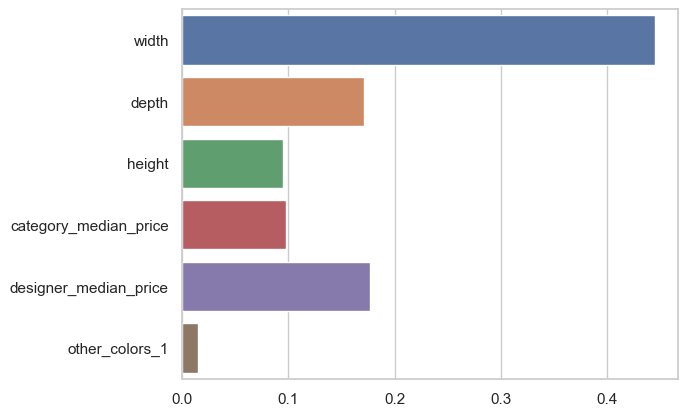

In [58]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X2, Y2, test_size=0.2, random_state=42)
forest_grid = GridSearchCV(RandomForestRegressor(), {'n_estimators': [10,50,100,110,120,130, 140,150,200,500], 
                                                     'max_depth': [10,100,200,None], 
                                                     'max_features': ['auto','sqrt','log2']}, cv=5, n_jobs=-1, verbose=3)
forest_grid.fit(X_train, Y_train)

print('Best Estimator :',forest_grid.best_estimator_)
print('Best Score     :',forest_grid.best_score_)
print('')
print('R^2            : {:.5f}'.format(sk.metrics.r2_score(Y_test, forest_grid.predict(X_test))))
print('MAE            : {:.5f}'.format(sk.metrics.mean_absolute_error(forest_grid.predict(X_test), Y_test)))
print('RMSE           : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(forest_grid.predict(X_test), Y_test))))
print('')
print('Feature importance:')
print('--------------------------------')
for feat, importance in zip(X_train.columns, forest_grid.best_estimator_.feature_importances_):
    print('{:.5f}    {f}'.format(importance, f=feat))

sns.set_style('whitegrid')
sns.barplot(y=X_train.columns, x=forest_grid.best_estimator_.feature_importances_)

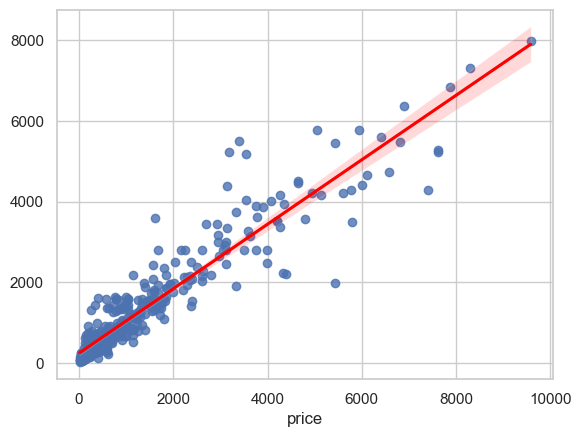

In [60]:
sns.regplot(x=Y_test, y=forest_grid.predict(X_test),line_kws={'color':'red'})
plt.show()

###### How to improve. Result description

It is necessary to improve the quality of the data to improve the quality of the model. 

As can be seen from the table and graph of the importance of the features, the "designers" have quite a large contribution. We can experiment with the encoding of the designers. In the case of teamwork, it is necessary to divide the group of designers into separate names and apply the approach to OneHotEncoder. 

Width describes the biggest part of furniture price.